# Project Exploration
## The Dataset and What we hope to do with it:
- The dataset we are using is the concatenated data of the 2015 Human Development Report, taken from Kaggle and developed by the United Nations.
- This data includes the average, standard deviation, min, and max of all variables that are a float, which is nice for describing it.
- It uses 45 variables that are supposed to describe the development of each of 195 listed countries. 
- A weird and potentially troublesome thing about this is it doesn't include all countries and has some 'countries' that are not always considered countries by definition. We will thus be taking out the 'countries' that are not recognized by the formal United Nations.
- Another issue is that there is a limitation of validity because the numbers are self reported and in some categories absent. We plan to take out some countries for their absence of data (taking out any with more than 10 missing values) and take our results with a grain of salt.

Our problem/goal: We hope to be able to use our model to find the GDI (Gender Development Index) from the HDI (Human Development Index) within the MDI (Multidimensional Poverty Index) of any country with our dataset. 
- We are going to keep the whole concatonated dataset and the MPI dataset seperate because they refer to different countries and we want to make multiple regression models that fit the NaN values between them before combining the dataset.

## Descriptive plots and graphs:

In [288]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import read_csv
import sklearn
import numpy as np
from pprint import pprint
import math 
import locale
from locale import atof
import numpy.random as rn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


locale.setlocale(locale.LC_NUMERIC, '')

gd_data = read_csv("https://www.dropbox.com/s/upot2a908xz26mn/gender_development.csv?dl=1")
gi_data = read_csv("https://www.dropbox.com/s/ensgp6e3chobe5x/gender_inequality.csv?dl=1")
hi_data = read_csv("https://www.dropbox.com/s/3u7udv2hlseddcb/historical_index.csv?dl=1")
ia_data = read_csv("https://www.dropbox.com/s/t7z4t0dj0ik16vc/inequality_adjusted.csv?dl=1")
hd_data = read_csv("https://www.dropbox.com/s/pjijqqsebk9vuwl/human_development.csv?dl=1")
mpi_data = read_csv('https://www.dropbox.com/s/jq78geqaa7qaobs/multidimensional_poverty.csv?dl=1')

In [289]:
whole_data = pd.concat([gd_data, gi_data,hd_data,ia_data,hi_data],axis=1,sort=False, copy = True).drop(['HDI Rank',
       'Human Development Index (HDI)'], axis =1)

In [290]:
whole_data = whole_data.loc[:,~whole_data.columns.duplicated()]

In [291]:
for column in whole_data.columns:
    for row in whole_data.index: 
        if whole_data.loc[row,column] == '..':
            whole_data.loc[row,column]= np.nan
for column in mpi_data.columns:
    for row in mpi_data.index: 
        if mpi_data.loc[row,column] == '..':
            mpi_data.loc[row,column]= np.nan

In [292]:
whole_data.drop(whole_data.index[188:194], axis =0)
whole_data =whole_data.drop(['Income Inequality (Quintile Ratio)','Income Inequality (Palma Rati)', 'Income Inequality (Gini Coefficient)'], axis =1)

In [293]:
mpi_data.head()

,Country,Year and Survey,"Multidimensional Poverty Index (MPI, HDRO)",MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,Afghanistan,2010/2011 M,0.293,58.8,0.353,66.2,"17,116",49.9,45.6,19.2,35.2,35.8,NaN
1,Albania,2008/2009 D,0.005,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,Argentina,2005 N,0.015,3.7,0.011,2.9,"1,438",39.1,38.2,27.8,34.0,NaN,1.4
3,Armenia,2010 D,0.002,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32.0,1.8
4,Azerbaijan,2006 D,0.009,2.4,0.021,5.3,210,38.2,20.0,50.7,29.3,5.3,0.3


In [294]:
for col in whole_data.columns:
    if col != 'Country':
        for i in range(len(whole_data[col])):
            if type(whole_data[col][i]) not in [np.float64, float] and whole_data[col][i] is not None:
                whole_data[col][i] = np.float64(whole_data[col][i].replace(",","_"))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [295]:
for col in mpi_data.columns:
    if col != 'Country' and col != 'Year and Survey':
        for i in range(len(mpi_data[col])):
            if type(mpi_data[col][i]) not in [np.float64, float] and mpi_data[col][i] is not None:
                mpi_data[col][i] = np.float64(mpi_data[col][i].replace(",","_"))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Regression Models for Filling Gaps
## Now we need to create regression models to fill in non-existant data points. To do this we must first drop points that have little to no data. 
- We use the loc feature to find all NaN  points. If there are >10 we will delete th erow to protect the integrity of the model. The following must be removed from the data set

- 'Hong Kong, China (SAR)'
- 'Liechtenstein'
- 'Brunei Darussalam' 
- 'Andorra' 
- 'Bahamas'
- 'Antigua and Barbuda'
- 'Palau'
- 'Seychelles' 
- 'Saint Kitts and Nevis'
- 'Grenada'
- 'Bosnia and Herzegovina'
- 'Dominica'
- 'Saint Vincent and the Grenadines'
- 'Turkmenistan'
- 'Gabon'
- 'Viet Nam'
- 'Cabo Verde'
- 'Micronesia (Federated States of)'
- 'Kiribati'
- 'Equatorial Guinea'
- 'Myanmar'
- 'Angola'
- 'Solomon Islands'
- 'Papua New Guinea'
- 'Haiti'
- 'Djibouti'
- 'Guinea-Bissau'
- 'Eritrea'

In [296]:
whole_data = whole_data.drop([whole_data.index[11], whole_data.index[12], whole_data.index[30], whole_data.index[33],
                 whole_data.index[54], whole_data.index[57] ,whole_data.index[59], whole_data.index[63], whole_data.index[76],
                 whole_data.index[78], whole_data.index[86], whole_data.index[93], whole_data.index[97],
                 whole_data.index[108], whole_data.index[109], whole_data.index[117], whole_data.index[121],
                 whole_data.index[122], whole_data.index[137], whole_data.index[136], whole_data.index[147],
                 whole_data.index[148], whole_data.index[156], whole_data.index[157], whole_data.index[162],
                 whole_data.index[167], whole_data.index[177], whole_data.index[185]], axis =0)

In [297]:
for column in whole_data.columns:
    df = whole_data[pd.notna(whole_data.loc[:,column])]
    df = df.dropna()

## whole_data
#### Now we need to find regression models (and test using bootstrapping and cross validation) for:
- Inequality in Education                                 
- Inequality-Adjusted Education Index                        
- Inequality in Income                                       
- Inequality-Adjusted Income Index 
- Inequality-adjusted HDI (IHDI)         
- IHDI Loss Percent                                         
- IHDI Rank Difference                                      
- Coefficient of Human Inequality                           
- Inequality in Life Expectancy  

##### We will create a vanilla regression, a  ridge regression, and lasso regression models for each to determine the missing values
______________________________________________________________________
# Functions

In [298]:
def createTestTrain(data,labelX,labely):
    X = np.atleast_2d(np.array([float(h) for h in data.loc[:, labelX].dropna()])).transpose()
    y = np.array(data.loc[:,labely])
    n = X.shape[0]
    test = int(0.20*n)           
    perm = rn.permutation(n)
    X = X[perm]
    y = y[perm]
    X_test = X[:test]      
    y_test = y[:test]
    X_train = X[test:]     
    y_train = y[test:]
    return X_test, y_test, X_train, y_train, X, y

In [299]:
def crossVal(X,y):  
    n = X.shape[0]
    test = int(0.20*n)           
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    R2 = pd.DataFrame( np.array([ [0]*5, [0]*5, [0]*5, [0]*5]).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])
    

    for k in range(5):
        X_test = X[k*test:(k+1)*test]      
        y_test = y[k*test:(k+1)*test]
        X_train = np.concatenate( (X[:k*test], X[(k+1)*test:]), axis=0)     
        y_train = np.concatenate( (y[:k*test], y[(k+1)*test:]), axis=0)
        reg = LinearRegression().fit(X_train, y_train)
        reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)

        R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
        R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
        R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
        R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

    R2mean = [0]*4
    R2std = [0]*4
    for c in range(4):
        R2mean[c] = np.mean(R2.iloc[0:5, c])
        R2std[c] = np.std(R2.iloc[0:5, c])

    R2 = R2.append( pd.Series(R2mean, index=R2.columns), ignore_index=True )
    R2 = R2.append( pd.Series(R2std, index=R2.columns), ignore_index=True)
    R2.index = [0, 1, 2, 3, 4, 'Mean', 'Standard Deviation']
    return R2

In [300]:
def boots(X,y):
    num = 40 
    Xboot = [0]*num
    yboot = [0]*num

    n = X.shape[0]
    for k in range(num):
        sample = np.random.randint(0, n, n) 
        Xboot[k] = X[sample, :]
        yboot[k] = y[sample]
    test = int(0.20*n)
    R2 = pd.DataFrame( np.array([ [0]*num]*4).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])

    for k in range(num):
        X_test = Xboot[k][:test]
        y_test = yboot[k][:test]
        X_train = Xboot[k][test:]
        y_train = yboot[k][test:]
        reg = LinearRegression().fit(X_train, y_train)
        reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)

        R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
        R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
        R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
        R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

    R2mean = [0]*4
    R2std = [0]*4
    for c in range(4):
        R2mean[c] = np.mean(R2.iloc[0:5, c])
        R2std[c] = np.std(R2.iloc[0:5, c])

    R2 = R2.append( pd.Series(R2mean, index=R2.columns), ignore_index=True )
    R2 = R2.append( pd.Series(R2std, index=R2.columns), ignore_index=True)
    R2.index = list(range(num)) + ['Mean', 'Standard Deviation']
    return R2.tail(10)

In [301]:
def plotfig():
    plt.plot(X_train, y_train, 'b.')
    plt.plot(X_test, y_test, 'g*')
    xx = np.linspace(0, 1.2, 20)
    yy = b + m*xx
    plt.plot(xx, yy, 'm-')

In [380]:
def filldata(data, m, b, index):
    ineq = data.columns[index]
    for row in range(len(ineq)):
        if np.isnan(data.iloc[row,index]):
            x = data.iloc[row,44]
            data.iloc[row,index] = m*x+b

In [381]:
def filldatampi(data, m, b, index):
    ineq = data.columns[index]
    for row in range(len(ineq)):
        if np.isnan(data.iloc[row,index]):
            x = data.iloc[row,2]
            data.iloc[row,index] = m*x+b

### Inequality in Education:

In [304]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality in Education")

69.37119946560425 -71.0795877951281


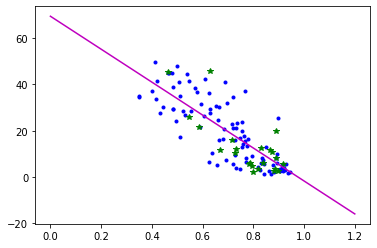

In [305]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [306]:
filldata(whole_data,m,b,34)

In [307]:
crossVal(X,y) 

,train_1,test_1,train_2,test_2
0,0.642242,0.714398,0.642242,0.714398
1,0.655913,0.572846,0.655913,0.572846
2,0.647656,0.661271,0.647656,0.661271
3,0.655173,0.599466,0.655173,0.599466
4,0.674050,0.517615,0.674050,0.517615
Mean,0.655007,0.613119,0.655007,0.613119
Standard Deviation,0.010775,0.068565,0.010775,0.068565


In [308]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.633570,0.385943,0.633570,0.385943
33,0.682025,0.519002,0.682025,0.519002
34,0.734558,0.670638,0.734558,0.670638
35,0.660318,0.756380,0.660318,0.756380
36,0.774786,0.425435,0.774786,0.425435
37,0.673600,0.625009,0.673600,0.625009
38,0.628236,0.577116,0.628236,0.577116
39,0.609524,0.680374,0.609524,0.680374
Mean,0.693014,0.596592,0.693014,0.596592
Standard Deviation,0.043708,0.094393,0.043708,0.094393


### Inequality-Adjusted Education Index:

In [309]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Human Development Index (2014)","Inequality-Adjusted Education Index")

-0.35535548887758217 1.278369757204203


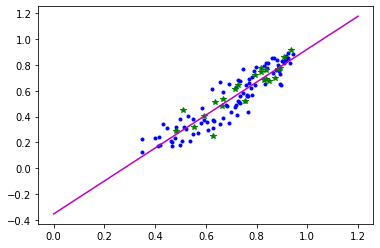

In [310]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [311]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8548290663845988
The testing R2: 0.8406358039917599


In [312]:
filldata(whole_data,m,b,35)

In [313]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.851805,0.869354,0.851805,0.869354
1,0.880796,0.620131,0.880796,0.620131
2,0.831346,0.915369,0.831346,0.915369
3,0.854368,0.839221,0.854368,0.839221
4,0.855580,0.843228,0.855580,0.843228
Mean,0.854779,0.817461,0.854779,0.817461
Standard Deviation,0.015720,0.102328,0.015720,0.102328


In [314]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.789460,0.846924,0.789460,0.846924
33,0.843521,0.742437,0.843521,0.742437
34,0.877018,0.844591,0.877018,0.844591
35,0.866988,0.889181,0.866988,0.889181
36,0.828681,0.853316,0.828681,0.853316
37,0.884711,0.738588,0.884711,0.738588
38,0.854128,0.823504,0.854128,0.823504
39,0.894106,0.795877,0.894106,0.795877
Mean,0.838026,0.850474,0.838026,0.850474
Standard Deviation,0.013267,0.043859,0.013267,0.043859


### Inequality-Adjusted Income Index:

In [315]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Human Development Index (2014)","Inequality-Adjusted Income Index")

-0.1999509047626825 1.0416253344751498


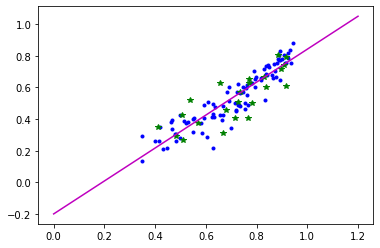

In [316]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [317]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8544913214325631
The testing R2: 0.6135263932827913


In [318]:
filldata(whole_data,m,b,37)

In [319]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.811502,0.816326,0.811502,0.816326
1,0.828182,0.739765,0.828182,0.739765
2,0.793323,0.874385,0.793323,0.874385
3,0.835707,0.683068,0.835707,0.683068
4,0.817585,0.804436,0.817585,0.804436
Mean,0.817260,0.783596,0.817260,0.783596
Standard Deviation,0.014600,0.065993,0.014600,0.065993


In [320]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.767503,0.853418,0.767503,0.853418
33,0.826158,0.680145,0.826158,0.680145
34,0.842505,0.769522,0.842505,0.769522
35,0.830766,0.850110,0.830766,0.850110
36,0.795569,0.819176,0.795569,0.819176
37,0.830583,0.810629,0.830583,0.810629
38,0.806695,0.835103,0.806695,0.835103
39,0.826804,0.914860,0.826804,0.914860
Mean,0.811565,0.745664,0.811565,0.745664
Standard Deviation,0.014812,0.172985,0.014812,0.172985


### Inequality-adjusted HDI (IHDI):

In [321]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality-adjusted HDI (IHDI)")

-0.24813383637072495 1.170712540965926


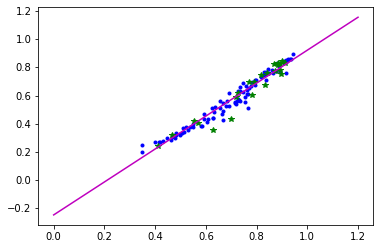

In [322]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [323]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.9609370520231372
The testing R2: 0.9250026601878651


In [324]:
filldata(whole_data,m,b,28)

In [325]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.953739,0.958969,0.953739,0.958969
1,0.954201,0.960906,0.954201,0.960906
2,0.958994,0.936445,0.958994,0.936445
3,0.962628,0.897073,0.962628,0.897073
4,0.947747,0.972636,0.947747,0.972636
Mean,0.955462,0.945206,0.955462,0.945206
Standard Deviation,0.005058,0.026765,0.005058,0.026765


In [326]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.953309,0.916750,0.953309,0.916750
33,0.960776,0.962143,0.960776,0.962143
34,0.947246,0.936750,0.947246,0.936750
35,0.935634,0.947356,0.935634,0.947356
36,0.959919,0.911765,0.959919,0.911765
37,0.953734,0.985139,0.953734,0.985139
38,0.963895,0.953749,0.963895,0.953749
39,0.963253,0.944104,0.963253,0.944104
Mean,0.952428,0.951806,0.952428,0.951806
Standard Deviation,0.005733,0.010430,0.005733,0.010430


### IHDI Loss Percent:

In [327]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","IHDI Loss Percent")

62.77726738114752 -60.37814525370304


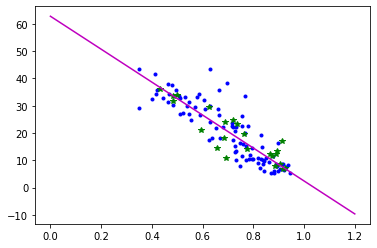

In [328]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [329]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.7549487885776806
The testing R2: 0.7596674508349154


In [330]:
filldata(whole_data,m,b,29)

In [331]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.718676,0.890985,0.718676,0.890985
1,0.726640,0.843816,0.726640,0.843816
2,0.773643,0.643876,0.773643,0.643876
3,0.785271,0.629105,0.785271,0.629105
4,0.783158,0.613130,0.783158,0.613130
Mean,0.757478,0.724182,0.757478,0.724182
Standard Deviation,0.028809,0.118285,0.028809,0.118285


In [332]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.774084,0.662695,0.774084,0.662695
33,0.706583,0.683429,0.706583,0.683429
34,0.800756,0.669566,0.800756,0.669566
35,0.731965,0.451803,0.731965,0.451803
36,0.762427,0.806781,0.762427,0.806781
37,0.726597,0.597562,0.726597,0.597562
38,0.812165,0.770319,0.812165,0.770319
39,0.755891,0.747890,0.755891,0.747890
Mean,0.787310,0.766949,0.787310,0.766949
Standard Deviation,0.054237,0.055744,0.054237,0.055744


### Coefficient of Human Inequality:

In [333]:
X_test, y_test, X_train, y_train,X, y = createTestTrain(df,"Human Development Index (2014)","Coefficient of Human Inequality")

59.513104890535644 -56.51065390982653


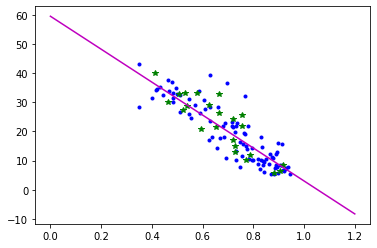

In [334]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [335]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.7757037403788303
The testing R2: 0.7524976860131


In [336]:
filldata(whole_data,m,b,31)

In [337]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.765854,0.811540,0.765854,0.811540
1,0.767405,0.800674,0.767405,0.800674
2,0.733528,0.913448,0.733528,0.913448
3,0.811326,0.614681,0.811326,0.614681
4,0.790851,0.688374,0.790851,0.688374
Mean,0.773793,0.765743,0.773793,0.765743
Standard Deviation,0.026172,0.103865,0.026172,0.103865


In [338]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.782167,0.666613,0.782167,0.666613
33,0.777147,0.663709,0.777147,0.663709
34,0.804723,0.832781,0.804723,0.832781
35,0.859120,0.880110,0.859120,0.880110
36,0.803663,0.649159,0.803663,0.649159
37,0.761803,0.749854,0.761803,0.749854
38,0.861107,0.877069,0.861107,0.877069
39,0.767639,0.659261,0.767639,0.659261
Mean,0.787412,0.802835,0.787412,0.802835
Standard Deviation,0.026016,0.079718,0.026016,0.079718


### Inequality in Life Expectancy: 

In [339]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality in Life Expectancy")

70.98595310378204 -76.91886026703824


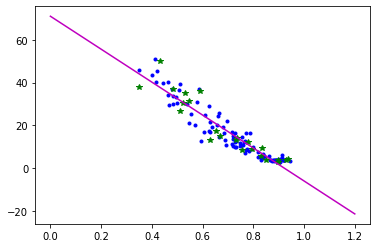

In [340]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [341]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8936768748155204
The testing R2: 0.8688891796967989


In [342]:
filldata(whole_data,m,b,31)

In [343]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.868733,0.948314,0.868733,0.948314
1,0.894332,0.847853,0.894332,0.847853
2,0.906541,0.775301,0.906541,0.775301
3,0.890244,0.873089,0.890244,0.873089
4,0.881300,0.899715,0.881300,0.899715
Mean,0.888230,0.868854,0.888230,0.868854
Standard Deviation,0.012687,0.057406,0.012687,0.057406


In [344]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.864543,0.894663,0.864543,0.894663
33,0.874734,0.930697,0.874734,0.930697
34,0.872449,0.835880,0.872449,0.835880
35,0.885805,0.917240,0.885805,0.917240
36,0.857711,0.941754,0.857711,0.941754
37,0.919816,0.793738,0.919816,0.793738
38,0.916077,0.919224,0.916077,0.919224
39,0.884683,0.878860,0.884683,0.878860
Mean,0.869613,0.883707,0.869613,0.883707
Standard Deviation,0.007956,0.026306,0.007956,0.026306


## mpi_data
#### We need to find regression models for:
- Population Below National Poverty Line
- Population Below $1.25 per Day

In [345]:
for column in mpi_data.columns:
    df = mpi_data[pd.notna(mpi_data.loc[:,column])]
    df = df.dropna()

In [362]:
mpi_data.columns.get_loc("Population Below $1.25 per Day")

12

### Population Below National Poverty Line

In [363]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Multidimensional Poverty Index (MPI, HDRO)","Population Below National Poverty Line")

25.193857154497344 65.2280961635629


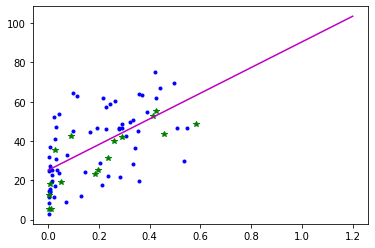

In [364]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [365]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.33977150003366396
The testing R2: 0.46191493859832766


In [366]:
filldatampi(mpi_data, m, b, 11)

In [367]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.373579,0.363366,0.373579,0.363366
1,0.420049,0.067493,0.420049,0.067493
2,0.307617,0.508301,0.307617,0.508301
3,0.383546,0.336295,0.383546,0.336295
4,0.398990,0.263283,0.398990,0.263283
Mean,0.376756,0.307748,0.376756,0.307748
Standard Deviation,0.037961,0.144104,0.037961,0.144104


In [368]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.270719,0.423470,0.270719,0.423470
33,0.363626,0.366159,0.363626,0.366159
34,0.443786,0.139345,0.443786,0.139345
35,0.532770,-0.244158,0.532770,-0.244158
36,0.360144,0.106828,0.360144,0.106828
37,0.323196,0.198302,0.323196,0.198302
38,0.191729,0.408765,0.191729,0.408765
39,0.671476,-0.070182,0.671476,-0.070182
Mean,0.398294,0.314528,0.398294,0.314528
Standard Deviation,0.109271,0.187558,0.109271,0.187558


### Population Below 1.25 per Day:

In [369]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Multidimensional Poverty Index (MPI, HDRO)","Population Below $1.25 per Day")

3.9393547585648925 109.82512675216336


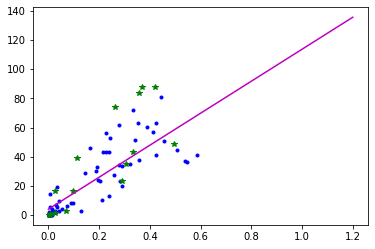

In [372]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [373]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.6752940046682944
The testing R2: 0.5310550917608874


In [374]:
filldatampi(mpi_data, m, b, 12)

In [375]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.653751,0.596801,0.653751,0.596801
1,0.618771,0.673944,0.618771,0.673944
2,0.653755,0.618217,0.653755,0.618217
3,0.709729,0.206650,0.709729,0.206650
4,0.624369,0.746493,0.624369,0.746493
Mean,0.652075,0.568421,0.652075,0.568421
Standard Deviation,0.032269,0.188153,0.032269,0.188153


In [376]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.706143,0.858214,0.706143,0.858214
33,0.647499,0.681559,0.647499,0.681559
34,0.589791,0.587095,0.589791,0.587095
35,0.689361,0.733636,0.689361,0.733636
36,0.661053,0.724812,0.661053,0.724812
37,0.689945,0.753679,0.689945,0.753679
38,0.747343,0.443788,0.747343,0.443788
39,0.695139,0.444013,0.695139,0.444013
Mean,0.686820,0.382030,0.686820,0.382030
Standard Deviation,0.024683,0.300621,0.024683,0.300621
